In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Introduction

This notebook is designed to give you more practice with PyMC3 syntax. 

It is intentionally designed to provide more guidance w.r.t. model definition, i.e. which parameters to use, such that the focus is more on PyMC3 syntax rather than the mechanics of model definition. 

If you are already feeling comfortable with PyMC3 syntax, and would like to instead move on to practice with model definition, then feel free to move onto notebook 5 instead, where you can play with the Darwin's Finches dataset. That notebook is intentionally designed with much more freedom.

## Setup

You will be experimentally analyzing the effectiveness of six different phone sterilization methods against two control methods. This research was conducted at MIT's Division of Comparative Medicine, and was published this year in the Journal of the American Association for Laboratory Animal Science. If you're interested, you can read the paper [here][jaalas].

[jaalas]: https://www.ncbi.nlm.nih.gov/pubmed/29402348

### Experiment Design

Briefly, the experiments were setup as such.

1. Pre-sterilization, three sites on the phone were swabbed and the number of colony forming units (CFUs) was determined by letting the swabbed bacteria grow on an agar plate.
1. Post-sterilization, the same three sites were swabbed and the number of CFUs was counted.
1. Sterilization efficacy was determined by taking the ratio of the difference of CFUs pre- and post-sterilization.

In the paper, we used the following formula to compute the percentage reduction:

$$\delta_{method} = \frac{{count}_{pre} - {count}_{post}}{{count}_{pre}}$$

In retrospect, a better definition would have been:

$$x = \frac{|{count}_{pre} - {count}_{post}|}{{count}_{pre}}$$
$$\delta_{method} = \begin{cases}
    0 & \text{if} & x\lt0, \\
    1 & \text{if} & x\gt1, \\
    x & \text{otherwise}
    \end{cases}$$

A few pointers:

- We want absolute value becuase sometimes, the number of colonies post-sterilization is greater than the number of colonies pre-sterilization, which may result randomly due to experimental variability.
- 

### Data

The data are located in `../data/sterilization.csv`.

In [12]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: Define Data Generating Process

Just as in the previous notebook, you may want to spend 5-10 minutes talking through the data generating process before proceeding. Most important is to list out the distributions that you think are most relevant to the problem.

### Step 2: Explore the Data

#### Exercise 1

Load the dataset into a pandas DataFrame. It is available at the path `../data/sterilization.csv`. 

In [17]:
df = pd.read_csv('../data/sterilization.csv', na_filter=True, na_values=['#DIV/0!'])
df.sample(5)

,sample_id,treatment,colonies_pre,colonies_post,perc_reduction colonies,morphologies_pre,morphologies_post,year,month,day,perc_reduction morph,site,phone ID,no case,screen protector
145,146,CB30,12,6,50.000000,3,3,NaN,NaN,NaN,0.0,case,51,NaN,NaN
156,157,CB30,15,7,53.333333,3,3,NaN,NaN,NaN,0.0,junction,54,NaN,NaN
181,182,cellblaster,5,4,20.000000,2,1,NaN,NaN,NaN,50.0,case,36,NaN,plastic
42,43,quatricide,3,0,100.000000,3,0,2015.0,12.0,8.0,100.0,phone,19,NaN,NaN
71,72,kimwipe,1,1,0.000000,1,1,NaN,NaN,NaN,0.0,phone,32,NaN,NaN


To help you visualize what data are available and missing in the dataframe, run the cell below to get a visual matrix (using MissingNo). 

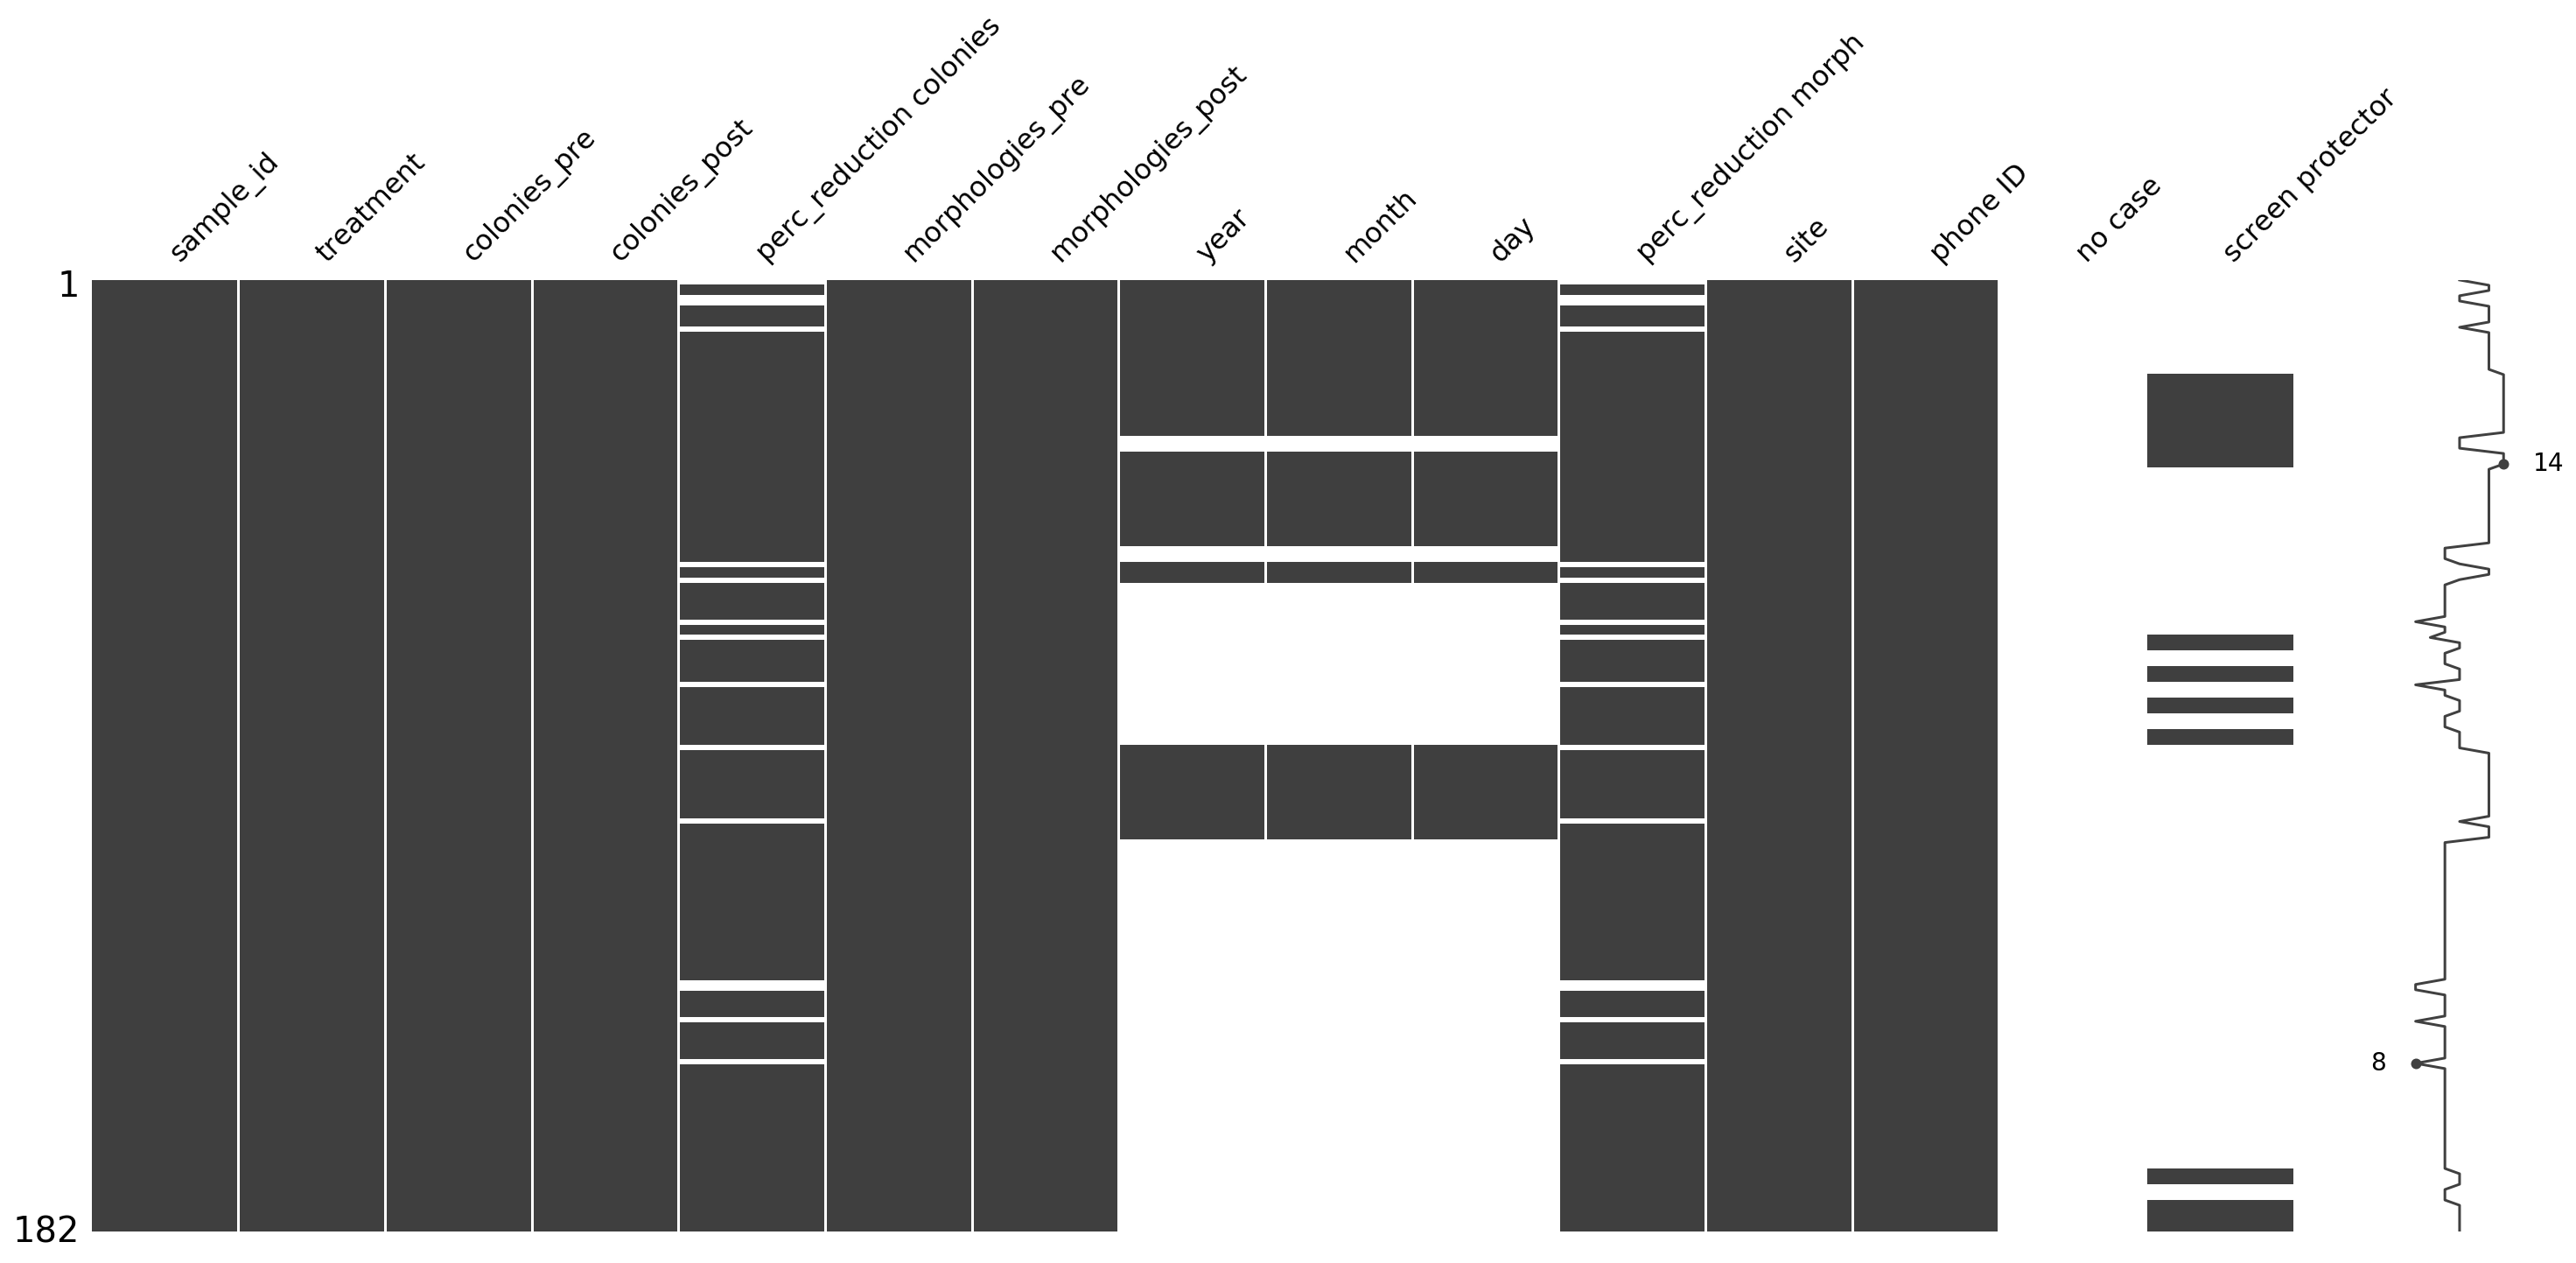

In [23]:
msno.matrix(df)

#### Exercise 2

Plot the average percentage reduction in colonies for each treatment.

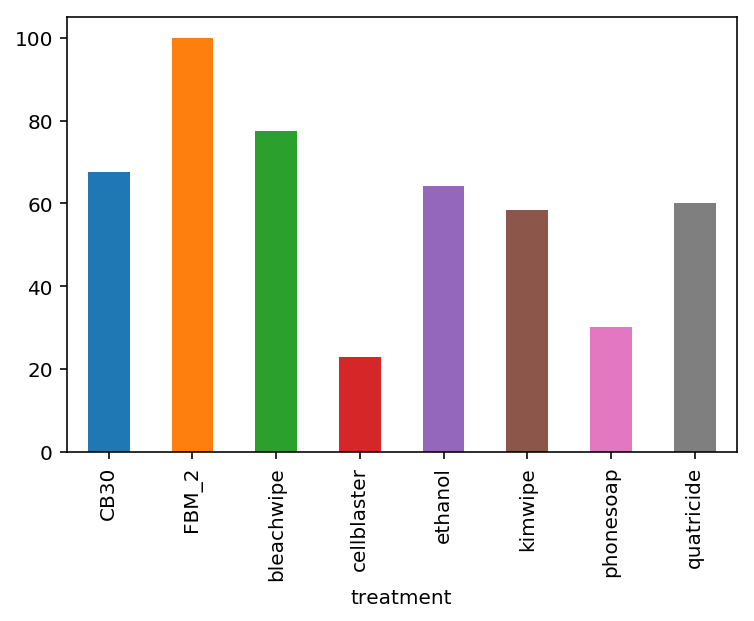

In [26]:
df.groupby('treatment').mean()['perc_reduction colonies'].plot(kind='bar')

In [27]:
df.describe()['']

,sample_id,colonies_pre,colonies_post,perc_reduction colonies,morphologies_pre,morphologies_post,year,month,day,perc_reduction morph,phone ID,no case
count,182.000000,182.000000,182.000000,167.000000,182.000000,182.000000,70.000000,70.000000,70.000000,167.000000,182.000000,0.0
mean,91.500000,19.252747,4.021978,58.855471,2.972527,1.170330,2015.400000,8.342857,11.671429,60.116196,21.758242,NaN
std,52.683014,23.327642,7.713056,142.404848,1.741376,1.370002,0.493435,3.265479,4.924713,49.625567,15.301999,NaN
min,1.000000,0.000000,0.000000,-1450.000000,0.000000,0.000000,2015.000000,4.000000,7.000000,-200.000000,1.000000,NaN
25%,46.250000,4.000000,0.000000,64.352941,2.000000,0.000000,2015.000000,5.000000,8.000000,33.333333,14.000000,NaN
50%,91.500000,11.000000,1.000000,94.444444,3.000000,1.000000,2015.000000,10.000000,10.000000,66.666667,18.000000,NaN
75%,136.750000,24.500000,4.000000,100.000000,4.000000,2.000000,2016.000000,11.000000,12.000000,100.000000,32.000000,NaN
max,182.000000,100.000000,47.000000,100.000000,8.000000,5.000000,2016.000000,12.000000,21.000000,100.000000,54.000000,NaN


### Step 3: Implement and Fit Model

#### Exercise

Write the generative model for the data. 

If you are stuck, feel free to look at the model definition as 

In [ ]:
with pm.Model() as model:
    
    
    
    